In [4]:
import pandas as pd
from collections import Counter, defaultdict
import networkx as nx
import pygraphviz as pgv
import seaborn as sns

ID_COL = 'Id'
train_date_path = './Bosch/train_date.csv'
test_date_path = './Bosch/test_date.csv'
train_numeric_path = './Bosch/train_numeric.csv'
test_numeric_path = './Bosch/test_numeric.csv'
train_cat_path = './Bosch/train_categorical.csv'
test_cat_path = './Bosch/test_categorical.csv'

pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Visualizing the shopfloor 
Date data contains the timestamp for each measured feature, be it numeric or categorical.


This is the file that will be used to visualize the stations and production lines. 

In [3]:
def update_counter_from_file(filepath,
                                  edges=True,
                                  counter=Counter(),
                                  chunksize=10000,
                                  drop_features=True,
                                  index_col=ID_COL):
    """
    filepath (str): path to csv file
                    column names are form the following format: L0_S0_D1
                    L0_S0_D1 is the time at which L0_S0_F0 was taken.
    edges (bool): are we counting single edges or full path
    counter (Counter instance): counter to update
    chunksize (int): provide chunksize if file to big to fit in memory
    index_col (str): column to use as index, item id.
    """
    dates = pd.read_csv(filepath,
                        chunksize=chunksize,
                        index_col=index_col)
    for date in dates:
        items_to_count = []
        if drop_features:
            date.rename({col: '_'.join(col.split('_')[:2]) for col in date.columns}, axis=1, inplace=True)
        not_null_msk  = date.T.notnull()
        for item in date.index.tolist():
            item_df = not_null_msk[item]
            if edges:
                vertices = list(dict.fromkeys(item_df[item_df].index.tolist()))
                items_to_count.extend([(vertices[i-1], vertices[i]) for i in range(1, len(vertices))])
            else:
                path = (', ').join(date.loc[item][date.loc[item].notna()].index.drop_duplicates().tolist())
                items_to_count.append(path) 
        counter.update(Counter(items_to_count))
    return counter

In [4]:
def plot_feature_count(filepath, index_col=ID_COL):
    df = pd.read_csv(filepath,
                     nrows=1,
                     index_col=index_col)
    stations = defaultdict(set)
    for col in df.columns:
        try:
            split = col.split('_')
            station = '_'.join(split[:2])
            feature = split[2]
            stations[station].add(feature)
        except:
            pass

    feature_counts = {s: len(f) for s, f in stations.items()}
    index = [ k for k in feature_counts]
    counts = [v for v in feature_counts.values()]
    to_plot = pd.DataFrame([index, counts]).T.rename({0: 'station', 1:'feature_count'}, axis=1).set_index('station')
    ax = to_plot.plot.bar(rot=70, alpha=0.75, figsize=(16, 9), fontsize='large', ylabel='feature_count', legend=False);

### Ensuring timestamps are increasing
Each item goes through several stations during its production.

It's important to ensure that these stations are the order in which the item paths and that there are no cases when an item goes back and forth.

Not all items are checked, only a sample. 

In [13]:
dates = pd.read_csv(train_date_path,
                        chunksize=10000,
                        index_col=ID_COL)
for date in dates:
    samples = date.sample(10)
    for item in samples.index.tolist():
        assert samples.loc[item].dropna().is_monotonic

In [19]:
edge_counter = update_counter_from_file(train_date_path)

In [20]:
edge_counter = update_counter_from_file(test_date_path,
                                        counter=edge_counter)

#### These are the most common edges
* Most common station transitions.
* Left is what station the item is coming from and right where the item is going. 
* The number indicates how many items passed there.

* e.g. **2236402** items passed from **production line 3 station 29** to **production line 3 station 30.** 

In [35]:
edge_counter.most_common(10)

[(('L3_S29', 'L3_S30'), 2236402),
 (('L3_S33', 'L3_S34'), 2226070),
 (('L3_S30', 'L3_S33'), 2114898),
 (('L0_S0', 'L0_S1'), 1346767),
 (('L3_S36', 'L3_S37'), 1137137),
 (('L3_S34', 'L3_S36'), 1131493),
 (('L3_S35', 'L3_S37'), 1103146),
 (('L3_S34', 'L3_S35'), 1098509),
 (('L0_S1', 'L0_S2'), 678332),
 (('L0_S6', 'L0_S8'), 677770)]

## Graph
### Entire shopfloor

In [30]:
G = pgv.AGraph(strict=False, directed=True)

In [31]:
ebunch = [(k[0], k[1], v) for k,v in edge_counter.items()]
ebunch_max, ebunch_min = ebunch[0][2], ebunch[-1][2]
reg_ebunch = [(x[0], x[1]) for x in ebunch]
out_nodes = set([k[0] for k,v in edge_counter.items()])
in_nodes = set([k[1] for k,v in edge_counter.items()])
sink_nodes = in_nodes - out_nodes
origin_nodes = out_nodes - in_nodes
norm_ebunch = []
for i, e in enumerate(ebunch):
    norm_ebunch.append((e[0], e[1], (e[2]-ebunch_min)/(ebunch_max-ebunch_min)*5))

#### Sink nodes and origin nodes
* sink node = station that doesn't have any "outgoing items".
* origin node = station that doesn't have any "incoming items".

In [32]:
sink_nodes, origin_nodes

({'L3_S38', 'L3_S51'}, {'L0_S0'})

In [33]:
lines = ['L0', 'L1', 'L2', 'L3']
colors = ['black', 'red', 'green', 'blue']
node_line = {}
edge_line = {}
for color, line in zip(colors, lines):
    node_line[line] = [k[0] for k,v in edge_counter.items() if line in k[0]]
    edge_line[line] = [k for k,v in edge_counter.items() if line in k[0]]
    G.add_nodes_from(node_line[line], color=color)
    G.add_edges_from(edge_line[line], color=color)

In [34]:
G.layout(prog="dot")
G.draw("shopfloor_full.png")

## Paths

In [48]:
path_counter = update_counter_from_file(train_date_path,
                                       edges=False)

In [49]:
path_counter = update_counter_from_file(test_date_path,
                                       counter=path_counter,
                                       edges=False)

### Most common paths
These are the 20 most common paths:

In [50]:
path_counter.most_common(20)

[('L1_S24, L2_S26, L3_S29, L3_S30, L3_S33, L3_S34, L3_S36, L3_S37', 116692),
 ('L1_S24, L2_S26, L3_S29, L3_S30, L3_S33, L3_S34, L3_S35, L3_S37', 112976),
 ('L1_S25, L2_S26, L3_S29, L3_S30, L3_S33, L3_S34, L3_S36, L3_S37', 46765),
 ('L1_S25, L2_S26, L3_S29, L3_S30, L3_S33, L3_S34, L3_S35, L3_S37', 45282),
 ('L1_S24, L2_S27, L3_S29, L3_S30, L3_S33, L3_S34, L3_S36, L3_S37', 42267),
 ('L1_S24, L2_S27, L3_S29, L3_S30, L3_S33, L3_S34, L3_S35, L3_S37', 40419),
 ('L1_S24_D1511, L1_S24_D1513, L1_S24_D1515, L1_S24_D1517, L1_S24_D1519, L1_S24_D1522, L1_S24_D1527, L1_S24_D1532, L1_S24_D1536, L1_S24_D1541, L1_S24_D1546, L1_S24_D1550, L1_S24_D1554, L1_S24_D1558, L1_S24_D1566, L1_S24_D1568, L1_S24_D1570, L1_S24_D1572, L1_S24_D1574, L1_S24_D1576, L1_S24_D1579, L1_S24_D1674, L1_S24_D1678, L1_S24_D1682, L1_S24_D1687, L1_S24_D1692, L1_S24_D1697, L1_S24_D1702, L1_S24_D1706, L1_S24_D1710, L1_S24_D1715, L1_S24_D1720, L1_S24_D1725, L1_S24_D1730, L1_S24_D1735, L1_S24_D1740, L1_S24_D1745, L1_S24_D1750, L1_S24_

### Visualizing the 7 most common paths
These paths contain similar stations and are the most common.

In [43]:
line_color = {line: color for line,color in zip(lines, colors)}

In [45]:
G = pgv.AGraph(strict=False, directed=True)

In [46]:
nodes, edges = set(), set()
edge_count = defaultdict(int)
for path in path_counter.most_common(7):
    try:
        path = path[0].replace(',', '').split()
        for node in path:
            nodes.add(node)
            line = node.split('_')[0]
            G.add_node(node, color=line_color[line])
        for i in range(1, len(path)):
            len_edges = len(edges)
            edges.add((path[i-1], path[i]))
            edge_count[(path[i-1], path[i])] += 1
            if len_edges<len(edges):
                line = path[i-1].split('_')[0]
                G.add_edge((path[i-1], path[i]), color=line_color[line])
    except Exception as e:
        print(e)

In [47]:
G.layout(prog="dot")
G.draw("most_common_paths.png")

### Feature count in ALL stations

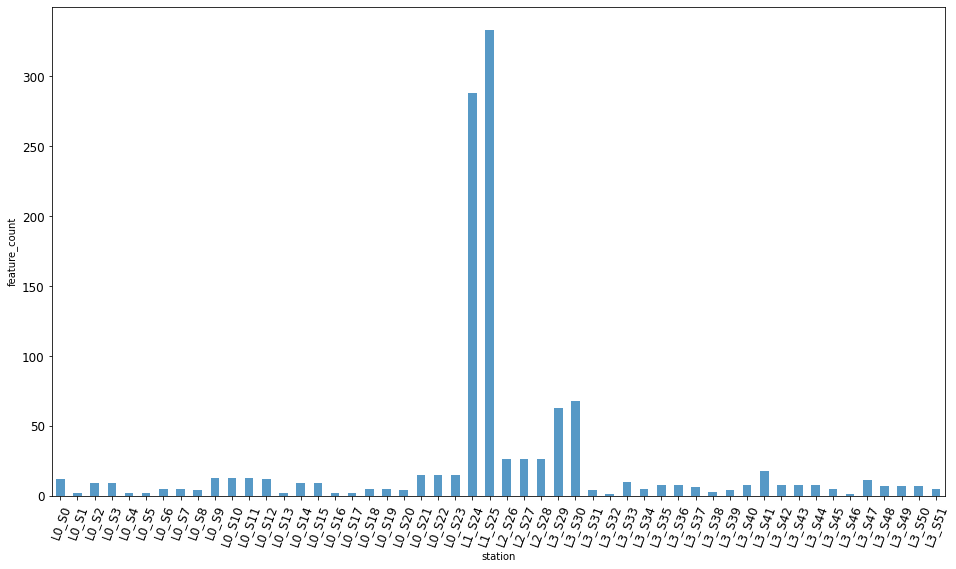

In [51]:
plot_feature_count(train_date_path)

# Numeric data

In [52]:
stations = set()
for path in path_counter.most_common(7):
    path = path[0].replace(',', '').split()
    for station in path:
        stations.add(station)

In [53]:
stations

{'L1_S24',
 'L1_S25',
 'L2_S26',
 'L2_S27',
 'L3_S29',
 'L3_S30',
 'L3_S33',
 'L3_S34',
 'L3_S35',
 'L3_S36',
 'L3_S37'}

In [61]:
df = pd.read_csv(train_numeric_path,
                 nrows=10,
                 index_col=ID_COL)
rel_columns = [col for col in df.columns if '_'.join(col.split('_')[:2]) in stations]

#### The most popular stations contain 70% of features!

In [63]:
len(rel_columns)/len(df.columns)

0.718266253869969

### Feature count per station

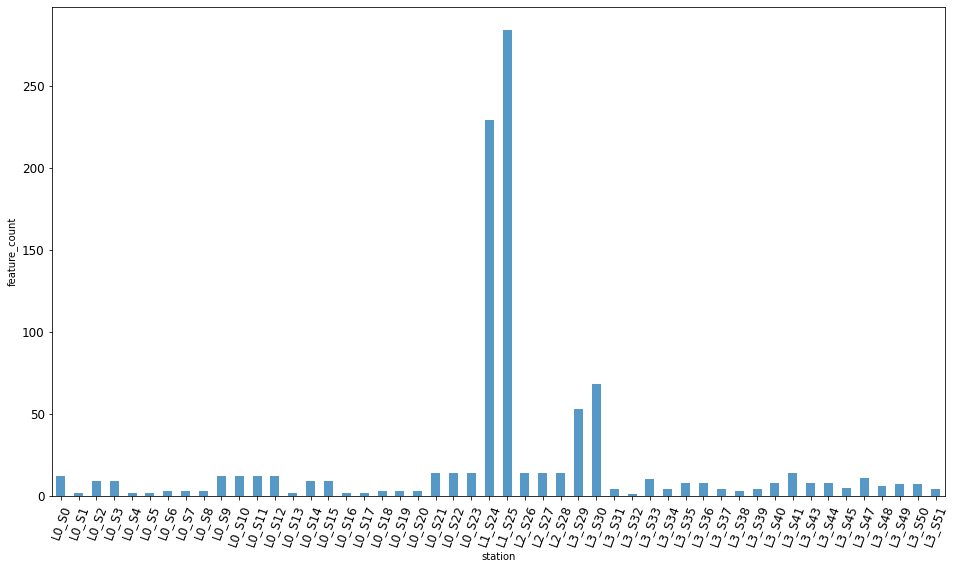

In [54]:
plot_feature_count(train_numeric_path)

# Categorical Data

In [39]:
df = pd.read_csv(train_cat_path, nrows=1)

In [40]:
len(df.columns)

2141

In [41]:
df.columns.tolist()[0:5]

['Id', 'L0_S1_F25', 'L0_S1_F27', 'L0_S1_F29', 'L0_S1_F31']

### Feature count per station:

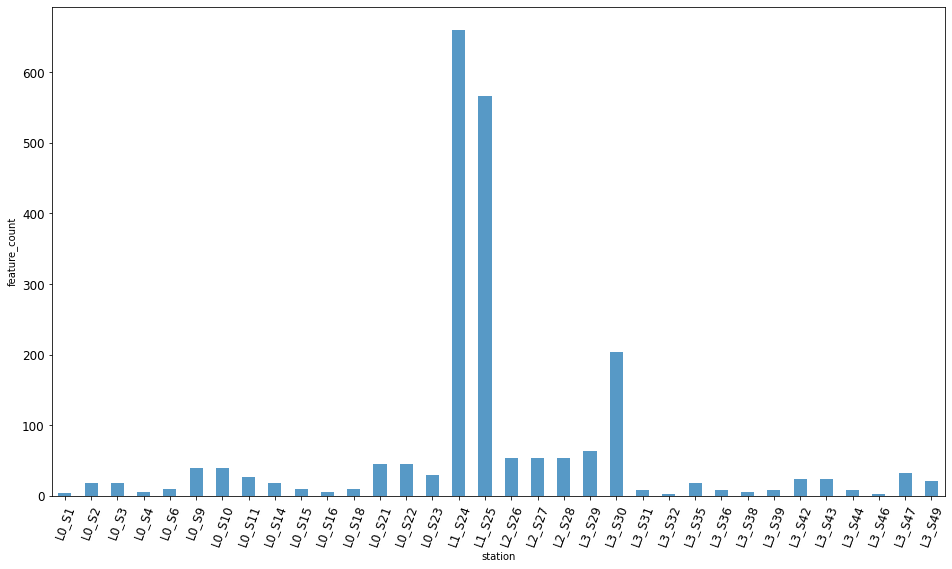

In [55]:
plot_feature_count(train_cat_path)

# Production duration
|value|  real duration|
|------|--------------|
|0.01 | 6 [min] |
|2.39| 1 [day]|
|16.75| 1 [week]|

https://www.kaggle.com/gaborfodor/notebookd19d11e4f2

In [64]:
spans = []
for date_path in [train_date_path, test_date_path]:
    dates = pd.read_csv(date_path, chunksize=10000, index_col=ID_COL)
    for date in dates:
        date.dropna(how='all', axis=1, inplace=True)
        date['max_'] = date.max(axis=1)
        date['min_'] = date.min(axis=1)
        date['span'] = date['max_'] - date['min_']
        spans.extend(date.span.tolist())

In [88]:
span_df = pd.DataFrame(spans, columns=['span'])
span_df['span_in_6minutes'] = span_df.span/0.01
span_df['span_in_hours'] = span_df.span/0.1

In [89]:
span_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,span,span_in_6minutes,span_in_hours
count,2366330.0000,2366330.0000,2366330.0000
mean,10.7082,1070.8217,107.0822
std,17.0312,1703.1242,170.3124
min,0.0000,0.0000,0.0000
5%,0.6100,61.0000,6.1000
25%,1.7100,171.0000,17.1000
50%,3.6900,369.0000,36.9000
75%,11.7600,1176.0000,117.6000
95%,42.8400,4284.0000,428.4000
99%,62.8100,6281.0000,628.1000


# Most common feature paths
Most common production paths that include the same features!

In [8]:
def get_feature_from_date(date_col):
    date_col = date_col.split('_')
    station = '_'.join(date_col[0:2])
    feature_number = int(date_col[2][1:]) - 1
    feature = 'F' + str(feature_number)
    feature_col = station + '_' + feature
    return feature_col

In [66]:
%%script False
path_counter = update_counter_from_file(train_date_path,
                                    drop_features=False,
                                    edges=False)
path_counter = update_counter_from_file(test_date_path,
                                    counter=path_counter,
                                    drop_features=False,
                                    edges=False)

Couldn't find program: 'False'


In [8]:
path_counter.most_common(2)

[('L1_S24_D1511, L1_S24_D1513, L1_S24_D1515, L1_S24_D1517, L1_S24_D1519, L1_S24_D1522, L1_S24_D1527, L1_S24_D1532, L1_S24_D1536, L1_S24_D1541, L1_S24_D1546, L1_S24_D1550, L1_S24_D1554, L1_S24_D1558, L1_S24_D1566, L1_S24_D1568, L1_S24_D1570, L1_S24_D1572, L1_S24_D1574, L1_S24_D1576, L1_S24_D1579, L1_S24_D1674, L1_S24_D1678, L1_S24_D1682, L1_S24_D1687, L1_S24_D1692, L1_S24_D1697, L1_S24_D1702, L1_S24_D1706, L1_S24_D1710, L1_S24_D1715, L1_S24_D1720, L1_S24_D1725, L1_S24_D1730, L1_S24_D1735, L1_S24_D1740, L1_S24_D1745, L1_S24_D1750, L1_S24_D1755, L1_S24_D1760, L1_S24_D1809, L1_S24_D1811, L1_S24_D1813, L1_S24_D1815, L1_S24_D1817, L1_S24_D1819, L1_S24_D1821, L1_S24_D1823, L1_S24_D1825, L1_S24_D1826, L1_S24_D1828, L1_S24_D1830, L1_S24_D1832, L1_S24_D1833, L1_S24_D1835, L1_S24_D1837, L1_S24_D1839, L1_S24_D1841, L1_S24_D1843, L1_S24_D1845, L1_S24_D1847, L1_S24_D1849, L1_S24_D1851, L2_S26_D3037, L2_S26_D3041, L2_S26_D3044, L2_S26_D3048, L2_S26_D3052, L2_S26_D3056, L2_S26_D3059, L2_S26_D3063, L2_

In [9]:
most_common_feature_paths = [paths[0] for paths in path_counter.most_common(2)]

In [52]:
#%%script False 
most_common_feature_paths = ['L1_S24_D1511, L1_S24_D1513, L1_S24_D1515, L1_S24_D1517, L1_S24_D1519, L1_S24_D1522, L1_S24_D1527, L1_S24_D1532, L1_S24_D1536, L1_S24_D1541, L1_S24_D1546, L1_S24_D1550, L1_S24_D1554, L1_S24_D1558, L1_S24_D1566, L1_S24_D1568, L1_S24_D1570, L1_S24_D1572, L1_S24_D1574, L1_S24_D1576, L1_S24_D1579, L1_S24_D1674, L1_S24_D1678, L1_S24_D1682, L1_S24_D1687, L1_S24_D1692, L1_S24_D1697, L1_S24_D1702, L1_S24_D1706, L1_S24_D1710, L1_S24_D1715, L1_S24_D1720, L1_S24_D1725, L1_S24_D1730, L1_S24_D1735, L1_S24_D1740, L1_S24_D1745, L1_S24_D1750, L1_S24_D1755, L1_S24_D1760, L1_S24_D1809, L1_S24_D1811, L1_S24_D1813, L1_S24_D1815, L1_S24_D1817, L1_S24_D1819, L1_S24_D1821, L1_S24_D1823, L1_S24_D1825, L1_S24_D1826, L1_S24_D1828, L1_S24_D1830, L1_S24_D1832, L1_S24_D1833, L1_S24_D1835, L1_S24_D1837, L1_S24_D1839, L1_S24_D1841, L1_S24_D1843, L1_S24_D1845, L1_S24_D1847, L1_S24_D1849, L1_S24_D1851, L2_S26_D3037, L2_S26_D3041, L2_S26_D3044, L2_S26_D3048, L2_S26_D3052, L2_S26_D3056, L2_S26_D3059, L2_S26_D3063, L2_S26_D3066, L2_S26_D3070, L2_S26_D3074, L2_S26_D3078, L2_S26_D3081, L2_S26_D3084, L2_S26_D3087, L2_S26_D3090, L2_S26_D3093, L2_S26_D3096, L2_S26_D3100, L2_S26_D3103, L2_S26_D3107, L2_S26_D3110, L2_S26_D3114, L2_S26_D3118, L2_S26_D3122, L2_S26_D3126, L3_S29_D3316, L3_S29_D3319, L3_S29_D3322, L3_S29_D3325, L3_S29_D3328, L3_S29_D3331, L3_S29_D3334, L3_S29_D3337, L3_S29_D3340, L3_S29_D3343, L3_S29_D3346, L3_S29_D3349, L3_S29_D3352, L3_S29_D3355, L3_S29_D3358, L3_S29_D3361, L3_S29_D3363, L3_S29_D3365, L3_S29_D3368, L3_S29_D3371, L3_S29_D3374, L3_S29_D3377, L3_S29_D3380, L3_S29_D3383, L3_S29_D3386, L3_S29_D3389, L3_S29_D3391, L3_S29_D3393, L3_S29_D3396, L3_S29_D3399, L3_S29_D3402, L3_S29_D3405, L3_S29_D3408, L3_S29_D3410, L3_S29_D3413, L3_S29_D3415, L3_S29_D3417, L3_S29_D3419, L3_S29_D3422, L3_S29_D3425, L3_S29_D3428, L3_S29_D3431, L3_S29_D3434, L3_S29_D3437, L3_S29_D3440, L3_S29_D3443, L3_S29_D3445, L3_S29_D3447, L3_S29_D3450, L3_S29_D3453, L3_S29_D3456, L3_S29_D3459, L3_S29_D3462, L3_S29_D3465, L3_S29_D3468, L3_S29_D3471, L3_S29_D3474, L3_S29_D3477, L3_S29_D3480, L3_S29_D3483, L3_S29_D3486, L3_S29_D3489, L3_S29_D3492, L3_S30_D3496, L3_S30_D3501, L3_S30_D3506, L3_S30_D3511, L3_S30_D3516, L3_S30_D3521, L3_S30_D3526, L3_S30_D3531, L3_S30_D3536, L3_S30_D3541, L3_S30_D3546, L3_S30_D3551, L3_S30_D3556, L3_S30_D3561, L3_S30_D3566, L3_S30_D3571, L3_S30_D3576, L3_S30_D3581, L3_S30_D3586, L3_S30_D3591, L3_S30_D3596, L3_S30_D3601, L3_S30_D3606, L3_S30_D3611, L3_S30_D3616, L3_S30_D3621, L3_S30_D3626, L3_S30_D3631, L3_S30_D3636, L3_S30_D3641, L3_S30_D3646, L3_S30_D3651, L3_S30_D3656, L3_S30_D3661, L3_S30_D3666, L3_S30_D3671, L3_S30_D3676, L3_S30_D3681, L3_S30_D3686, L3_S30_D3691, L3_S30_D3696, L3_S30_D3701, L3_S30_D3706, L3_S30_D3711, L3_S30_D3716, L3_S30_D3721, L3_S30_D3726, L3_S30_D3731, L3_S30_D3736, L3_S30_D3741, L3_S30_D3746, L3_S30_D3751, L3_S30_D3756, L3_S30_D3761, L3_S30_D3766, L3_S30_D3771, L3_S30_D3776, L3_S30_D3781, L3_S30_D3786, L3_S30_D3791, L3_S30_D3796, L3_S30_D3801, L3_S30_D3806, L3_S30_D3811, L3_S30_D3816, L3_S30_D3821, L3_S30_D3826, L3_S30_D3831, L3_S33_D3856, L3_S33_D3858, L3_S33_D3860, L3_S33_D3862, L3_S33_D3864, L3_S33_D3866, L3_S33_D3868, L3_S33_D3870, L3_S33_D3872, L3_S33_D3874, L3_S34_D3875, L3_S34_D3877, L3_S34_D3879, L3_S34_D3881, L3_S34_D3883, L3_S36_D3919, L3_S36_D3921, L3_S36_D3923, L3_S36_D3925, L3_S36_D3928, L3_S36_D3932, L3_S36_D3936, L3_S36_D3940, L3_S37_D3942, L3_S37_D3943, L3_S37_D3945, L3_S37_D3947, L3_S37_D3949, L3_S37_D3951',
                             'L1_S24_D1511, L1_S24_D1513, L1_S24_D1515, L1_S24_D1517, L1_S24_D1519, L1_S24_D1522, L1_S24_D1527, L1_S24_D1532, L1_S24_D1536, L1_S24_D1541, L1_S24_D1546, L1_S24_D1550, L1_S24_D1554, L1_S24_D1558, L1_S24_D1566, L1_S24_D1568, L1_S24_D1570, L1_S24_D1572, L1_S24_D1574, L1_S24_D1576, L1_S24_D1579, L1_S24_D1583, L1_S24_D1587, L1_S24_D1591, L1_S24_D1596, L1_S24_D1601, L1_S24_D1606, L1_S24_D1611, L1_S24_D1615, L1_S24_D1619, L1_S24_D1624, L1_S24_D1629, L1_S24_D1634, L1_S24_D1639, L1_S24_D1644, L1_S24_D1649, L1_S24_D1654, L1_S24_D1659, L1_S24_D1664, L1_S24_D1669, L1_S24_D1765, L1_S24_D1770, L1_S24_D1775, L1_S24_D1780, L1_S24_D1785, L1_S24_D1790, L1_S24_D1795, L1_S24_D1800, L1_S24_D1805, L1_S24_D1826, L1_S24_D1828, L1_S24_D1830, L1_S24_D1832, L1_S24_D1833, L1_S24_D1835, L1_S24_D1837, L1_S24_D1839, L1_S24_D1841, L1_S24_D1843, L1_S24_D1845, L1_S24_D1847, L1_S24_D1849, L1_S24_D1851, L2_S26_D3037, L2_S26_D3041, L2_S26_D3044, L2_S26_D3048, L2_S26_D3052, L2_S26_D3056, L2_S26_D3059, L2_S26_D3063, L2_S26_D3066, L2_S26_D3070, L2_S26_D3074, L2_S26_D3078, L2_S26_D3081, L2_S26_D3084, L2_S26_D3087, L2_S26_D3090, L2_S26_D3093, L2_S26_D3096, L2_S26_D3100, L2_S26_D3103, L2_S26_D3107, L2_S26_D3110, L2_S26_D3114, L2_S26_D3118, L2_S26_D3122, L2_S26_D3126, L3_S29_D3316, L3_S29_D3319, L3_S29_D3322, L3_S29_D3325, L3_S29_D3328, L3_S29_D3331, L3_S29_D3334, L3_S29_D3337, L3_S29_D3340, L3_S29_D3343, L3_S29_D3346, L3_S29_D3349, L3_S29_D3352, L3_S29_D3355, L3_S29_D3358, L3_S29_D3361, L3_S29_D3363, L3_S29_D3365, L3_S29_D3368, L3_S29_D3371, L3_S29_D3374, L3_S29_D3377, L3_S29_D3380, L3_S29_D3383, L3_S29_D3386, L3_S29_D3389, L3_S29_D3391, L3_S29_D3393, L3_S29_D3396, L3_S29_D3399, L3_S29_D3402, L3_S29_D3405, L3_S29_D3408, L3_S29_D3410, L3_S29_D3413, L3_S29_D3415, L3_S29_D3417, L3_S29_D3419, L3_S29_D3422, L3_S29_D3425, L3_S29_D3428, L3_S29_D3431, L3_S29_D3434, L3_S29_D3437, L3_S29_D3440, L3_S29_D3443, L3_S29_D3445, L3_S29_D3447, L3_S29_D3450, L3_S29_D3453, L3_S29_D3456, L3_S29_D3459, L3_S29_D3462, L3_S29_D3465, L3_S29_D3468, L3_S29_D3471, L3_S29_D3474, L3_S29_D3477, L3_S29_D3480, L3_S29_D3483, L3_S29_D3486, L3_S29_D3489, L3_S29_D3492, L3_S30_D3496, L3_S30_D3501, L3_S30_D3506, L3_S30_D3511, L3_S30_D3516, L3_S30_D3521, L3_S30_D3526, L3_S30_D3531, L3_S30_D3536, L3_S30_D3541, L3_S30_D3546, L3_S30_D3551, L3_S30_D3556, L3_S30_D3561, L3_S30_D3566, L3_S30_D3571, L3_S30_D3576, L3_S30_D3581, L3_S30_D3586, L3_S30_D3591, L3_S30_D3596, L3_S30_D3601, L3_S30_D3606, L3_S30_D3611, L3_S30_D3616, L3_S30_D3621, L3_S30_D3626, L3_S30_D3631, L3_S30_D3636, L3_S30_D3641, L3_S30_D3646, L3_S30_D3651, L3_S30_D3656, L3_S30_D3661, L3_S30_D3666, L3_S30_D3671, L3_S30_D3676, L3_S30_D3681, L3_S30_D3686, L3_S30_D3691, L3_S30_D3696, L3_S30_D3701, L3_S30_D3706, L3_S30_D3711, L3_S30_D3716, L3_S30_D3721, L3_S30_D3726, L3_S30_D3731, L3_S30_D3736, L3_S30_D3741, L3_S30_D3746, L3_S30_D3751, L3_S30_D3756, L3_S30_D3761, L3_S30_D3766, L3_S30_D3771, L3_S30_D3776, L3_S30_D3781, L3_S30_D3786, L3_S30_D3791, L3_S30_D3796, L3_S30_D3801, L3_S30_D3806, L3_S30_D3811, L3_S30_D3816, L3_S30_D3821, L3_S30_D3826, L3_S30_D3831, L3_S33_D3856, L3_S33_D3858, L3_S33_D3860, L3_S33_D3862, L3_S33_D3864, L3_S33_D3866, L3_S33_D3868, L3_S33_D3870, L3_S33_D3872, L3_S33_D3874, L3_S34_D3875, L3_S34_D3877, L3_S34_D3879, L3_S34_D3881, L3_S34_D3883, L3_S36_D3919, L3_S36_D3921, L3_S36_D3923, L3_S36_D3925, L3_S36_D3928, L3_S36_D3932, L3_S36_D3936, L3_S36_D3940, L3_S37_D3942, L3_S37_D3943, L3_S37_D3945, L3_S37_D3947, L3_S37_D3949, L3_S37_D3951']
most_common_feature_paths = [x.split(', ') for x in most_common_feature_paths]

In [64]:
numeric_cols = set(pd.read_csv(train_numeric_path, nrows=1, index_col=ID_COL).columns.tolist())

In [65]:
path_items = {}
for i in range(len(most_common_feature_paths)):
    features = set([get_feature_from_date(x) for x in most_common_feature_paths[i]])
    features = features&numeric_cols
    date_features = most_common_feature_paths[i] +[ID_COL]

    rel_items = []
    for filepath in [train_date_path, test_date_path]:
        dates = pd.read_csv(filepath,
                        chunksize=10000,
                        index_col=ID_COL,
                        usecols=date_features)
        for date in dates:
            rel_items.extend(date.dropna(how='any', axis=0).index.tolist())
    path_items[i] = rel_items 

In [73]:
item_df_for_path = {}
for i in range(len(most_common_feature_paths)):
    features = set([get_feature_from_date(x) for x in most_common_feature_paths[i]])
    features = features&numeric_cols
    numeric_dfs = []
    for filepath in [train_numeric_path, test_numeric_path]:
        numerics = pd.read_csv(filepath,
                        index_col=ID_COL,
                        usecols=list(features)+[ID_COL])
        numerics = numerics[numerics.index.isin(path_items[i])]
        numeric_dfs.append(numerics)
    item_df_for_path[i] = pd.concat(numeric_dfs, axis=0)

### #1 most common

In [76]:
item_df_for_path[0].describe()

,L1_S24_F1512,L1_S24_F1514,L1_S24_F1516,L1_S24_F1518,L1_S24_F1565,L1_S24_F1567,L1_S24_F1569,L1_S24_F1571,L1_S24_F1573,L1_S24_F1575,L1_S24_F1578,L1_S24_F1808,L1_S24_F1810,L1_S24_F1812,L1_S24_F1814,L1_S24_F1816,L1_S24_F1818,L1_S24_F1820,L1_S24_F1822,L1_S24_F1824,L1_S24_F1829,L1_S24_F1831,L1_S24_F1834,L1_S24_F1836,L1_S24_F1838,L1_S24_F1840,L1_S24_F1842,L1_S24_F1844,L1_S24_F1846,L1_S24_F1848,L1_S24_F1850,L2_S26_F3036,L2_S26_F3040,L2_S26_F3047,L2_S26_F3051,L2_S26_F3055,L2_S26_F3062,L2_S26_F3069,L2_S26_F3073,L2_S26_F3077,L2_S26_F3106,L2_S26_F3113,L2_S26_F3117,L2_S26_F3121,L2_S26_F3125,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,L3_S29_F3345,L3_S29_F3348,L3_S29_F3351,L3_S29_F3354,L3_S29_F3357,L3_S29_F3360,L3_S29_F3367,L3_S29_F3370,L3_S29_F3373,L3_S29_F3376,L3_S29_F3379,L3_S29_F3382,L3_S29_F3385,L3_S29_F3388,L3_S29_F3395,L3_S29_F3398,L3_S29_F3401,L3_S29_F3404,L3_S29_F3407,L3_S29_F3412,L3_S29_F3421,L3_S29_F3424,L3_S29_F3427,L3_S29_F3430,L3_S29_F3433,L3_S29_F3436,L3_S29_F3439,L3_S29_F3442,L3_S29_F3449,L3_S29_F3452,L3_S29_F3455,L3_S29_F3458,L3_S29_F3461,L3_S29_F3464,L3_S29_F3467,L3_S29_F3470,L3_S29_F3473,L3_S29_F3476,L3_S29_F3479,L3_S29_F3482,L3_S29_F3485,L3_S29_F3488,L3_S29_F3491,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S36_F3918,L3_S36_F3920,L3_S36_F3922,L3_S36_F3924,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950
count,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000,24149.0000
mean,-0.0016,-0.0024,0.0002,0.0013,-0.0092,0.0087,-0.0126,-0.0123,-0.0179,0.0063,0.0064,-0.0219,-0.0007,0.0099,-0.0026,0.0172,0.0065,0.0001,0.0050,-0.0067,0.0086,-0.0022,0.0087,0.0063,-0.0092,0.0000,-0.0135,-0.0099,0.1225,0.0086,-0.0078,0.0571,0.0107,0.0002,-0.0076,-0.0009,-0.0135,0.0127,0.0326,-0.0007,0.0184,0.0087,0.0237,0.0064,-0.0013,-0.0380,-0.0146,0.0477,-0.0147,0.0429,0.0376,0.0054,0.0061,0.0264,0.0268,-0.0682,-0.0763,-0.0546,-0.0068,-0.0246,0.0014,-0.0147,0.0061,-0.0108,0.0090,0.0301,0.0025,0.0477,0.0054,-0.0763,0.0014,-0.0682,-0.0246,0.0593,0.0593,-0.0146,0.0376,-0.0056,0.0436,-0.0091,0.0376,-0.0380,0.0429,0.0268,-0.0068,0.0264,-0.0546,-0.0186,0.1440,-0.0186,0.1440,-0.0119,-0.0072,-0.0125,-0.0001,0.0000,0.0000,0.0000,-0.0230,-0.0222,0.0076,-0.0230,-0.0230,0.0012,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0507,-0.0162,-0.0507,-0.0162,0.0000,0.0000,0.0000,0.0000
std,0.0538,0.1079,0.0776,0.0304,0.0765,0.1488,0.1557,0.1500,0.1868,0.1570,0.0527,0.2500,0.0332,0.1254,0.0673,0.1481,0.1285,0.0556,0.1213,0.0834,0.1121,0.1552,0.1488,0.1570,0.0765,0.0062,0.2262,0.1961,0.0613,0.1117,

### #2 most common

In [77]:
item_df_for_path[1].describe()

,L1_S24_F1512,L1_S24_F1514,L1_S24_F1516,L1_S24_F1518,L1_S24_F1565,L1_S24_F1567,L1_S24_F1569,L1_S24_F1571,L1_S24_F1573,L1_S24_F1575,L1_S24_F1578,L1_S24_F1829,L1_S24_F1831,L1_S24_F1834,L1_S24_F1836,L1_S24_F1838,L1_S24_F1840,L1_S24_F1842,L1_S24_F1844,L1_S24_F1846,L1_S24_F1848,L1_S24_F1850,L2_S26_F3036,L2_S26_F3040,L2_S26_F3047,L2_S26_F3051,L2_S26_F3055,L2_S26_F3062,L2_S26_F3069,L2_S26_F3073,L2_S26_F3077,L2_S26_F3106,L2_S26_F3113,L2_S26_F3117,L2_S26_F3121,L2_S26_F3125,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,L3_S29_F3345,L3_S29_F3348,L3_S29_F3351,L3_S29_F3354,L3_S29_F3357,L3_S29_F3360,L3_S29_F3367,L3_S29_F3370,L3_S29_F3373,L3_S29_F3376,L3_S29_F3379,L3_S29_F3382,L3_S29_F3385,L3_S29_F3388,L3_S29_F3395,L3_S29_F3398,L3_S29_F3401,L3_S29_F3404,L3_S29_F3407,L3_S29_F3412,L3_S29_F3421,L3_S29_F3424,L3_S29_F3427,L3_S29_F3430,L3_S29_F3433,L3_S29_F3436,L3_S29_F3439,L3_S29_F3442,L3_S29_F3449,L3_S29_F3452,L3_S29_F3455,L3_S29_F3458,L3_S29_F3461,L3_S29_F3464,L3_S29_F3467,L3_S29_F3470,L3_S29_F3473,L3_S29_F3476,L3_S29_F3479,L3_S29_F3482,L3_S29_F3485,L3_S29_F3488,L3_S29_F3491,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S36_F3918,L3_S36_F3920,L3_S36_F3922,L3_S36_F3924,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950
count,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000,23918.0000
mean,-0.0025,-0.0018,-0.0005,0.0012,-0.0090,0.0100,-0.0138,-0.0135,-0.0184,0.0078,0.0062,-0.0065,-0.0054,0.0100,0.0078,-0.0090,0.0000,0.0138,0.0123,-0.1220,-0.0065,0.0078,0.0575,0.0107,0.0002,-0.0075,0.0002,-0.0138,0.0133,0.0317,0.0003,0.0183,0.0083,0.0223,0.0060,-0.0018,-0.0337,-0.0142,0.0458,-0.0143,0.0426,0.0376,0.0055,0.0061,0.0262,0.0265,-0.0678,-0.0756,-0.0533,-0.0047,-0.0244,-0.0000,-0.0143,0.0061,-0.0093,0.0090,0.0284,0.0027,0.0458,0.0055,-0.0756,-0.0000,-0.0678,-0.0244,0.0593,0.0593,-0.0142,0.0376,-0.0051,0.0433,-0.0100,0.0377,-0.0337,0.0426,0.0265,-0.0047,0.0262,-0.0533,-0.0184,0.1400,-0.0184,0.1400,-0.0117,-0.0072,-0.0125,-0.0001,0.0000,0.0000,0.0000,-0.0220,-0.0213,0.0069,-0.0220,-0.0220,0.0013,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0503,-0.0167,-0.0503,-0.0167,0.0000,0.0000,0.0000,0.0000
std,0.0530,0.1079,0.0773,0.0301,0.0752,0.1489,0.1556,0.1497,0.1863,0.1571,0.0530,0.1135,0.1551,0.1489,0.1571,0.0752,0.0000,0.2139,0.1889,0.0596,0.1126,0.0507,0.1531,0.0618,0.1533,0.1066,0.1568,0.0942,0.1210,0.1184,0.1780,0.0612,0.1203,0.0873,0.0829,0.1698,0.1903,0.1188,0.1761,0.1578,0.0950,0.0768,0.0665,0.0638,0.0862,0.0822,0.1117,0.1244,0.1499,0.1564,0.0365,0.1590,0.1578,0.0638,0.2172,0.0620,0.2522,0.0616,0.1761,0.0665,0.1244,0.1590,0.1117,0.0365,0.0030,0.0030,0.1188,0.0768,0.1330,0.0963,0.

## Remarks:
The two most common feature sets seem to be very similar. 

The second most common one's features are fully contained in the first. 

This can be similar items produced or that some metrics aren't measured for every item in this group.

The most common feature set has 9 more features in L1_S24.

In [89]:
cols0 = set(item_df_for_path[0].columns)
cols1 = set(item_df_for_path[1].columns)
cols0 - cols1

{'L1_S24_F1808',
 'L1_S24_F1810',
 'L1_S24_F1812',
 'L1_S24_F1814',
 'L1_S24_F1816',
 'L1_S24_F1818',
 'L1_S24_F1820',
 'L1_S24_F1822',
 'L1_S24_F1824'}

In [90]:
cols1 - cols0

set()

# Production duration

### Span for most common paths

In [96]:
spans = []
for i in range(len(most_common_feature_paths)):
    date_features = most_common_feature_paths[i] +[ID_COL]
    for date_path in [train_date_path, test_date_path]:
        dates = pd.read_csv(date_path, usecols=date_features, index_col=ID_COL)
        dates = dates[dates.index.isin(path_items[i])]
        dates['max_'] = dates.max(axis=1)
        dates['min_'] = dates.min(axis=1)
        dates['span'] = dates['max_'] - dates['min_']
        spans.append(dates.span.tolist())

In [100]:
span_most_common_path = spans[0] + spans[1]
span_2nd_most_common_path = spans[2] + spans[3]

## Most common path:

In [102]:
span_df = pd.DataFrame(span_most_common_path, columns=['span'])
span_df['span_in_6minutes'] = span_df.span/0.01
span_df['span_in_hours'] = span_df.span/0.1

In [103]:
span_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,span,span_in_6minutes,span_in_hours
count,24149.0000,24149.0000,24149.0000
mean,26.4243,2642.4322,264.2432
std,14.3908,1439.0787,143.9079
min,2.8700,287.0000,28.7000
5%,9.0600,906.0000,90.6000
25%,16.2400,1624.0000,162.4000
50%,22.9100,2291.0000,229.1000
75%,37.0000,3700.0000,370.0000
95%,44.7500,4475.0000,447.5000
99%,51.1000,5110.0000,511.0000


## Second most common path:

In [106]:
span_df = pd.DataFrame(span_2nd_most_common_path, columns=['span'])
span_df['span_in_6minutes'] = span_df.span/0.01
span_df['span_in_hours'] = span_df.span/0.1

In [107]:
span_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,span,span_in_6minutes,span_in_hours
count,23918.0000,23918.0000,23918.0000
mean,26.4372,2643.7203,264.3720
std,14.3594,1435.9442,143.5944
min,2.8700,287.0000,28.7000
5%,9.0900,909.0000,90.9000
25%,16.2500,1625.0000,162.5000
50%,22.9500,2295.0000,229.5000
75%,36.9975,3699.7500,369.9750
95%,44.6000,4460.0000,446.0000
99%,51.0900,5109.0000,510.9000
